In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

from tensorflow.keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import tensorflow as tf


!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fid = drive.ListFile({'q':"title='facemo.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('facemo.zip')
f.keys()
!unzip facemo.zip

In [24]:
gpus = tf.config.list_logical_devices('GPU') 
stg=tf.distribute.MirroredStrategy(gpus)

In [25]:
folder_path = "/content/facemo/images/" 
# folder_path = "../input/face-expression-recognition-dataset/images/"
# validation_folder_path = "../input/face-expression-recognition-dataset/images/"

In [26]:
import cv2
import os
from tqdm import tqdm

folder_dir = '/content/facemo/images/train'
SIZE = (48,48) 
DOWNSAMPLE_RATIO = 4
JPEG_QUALITY = 80

# get the total number of files to process
total_files = sum(len(files) for _, _, files in os.walk(folder_dir))

# use tqdm to display a progress bar
with tqdm(total=total_files, desc="Processing Images") as pbar:
    for folder in os.listdir(folder_dir):
        for file in os.listdir(os.path.join(folder_dir, folder)):
            if file.endswith("jpg"):
                image_path = os.path.join(folder_dir, folder, file)
                img = cv2.imread(image_path)
                img_resized = cv2.resize(img, (SIZE))
                cv2.imwrite(image_path, img_resized)
                pbar.update(1) # increment the progress bar
            else:
                continue


Processing Images: 100%|██████████| 2827/2827 [00:00<00:00, 2873.08it/s]


In [27]:
'''
expression = 'happy'
plt.style.use('dark_background')
plt.figure(figsize=(12, 12))
for i in range(1, 10):
    plt.subplot(3, 3, i)
    img = load_img(folder_path + "train/" + expression + "/" + os.listdir(folder_path + "train/" + expression)[i], target_size=SIZE)
    plt.imshow(img)  
plt.show()
'''

'\nexpression = \'happy\'\nplt.style.use(\'dark_background\')\nplt.figure(figsize=(12, 12))\nfor i in range(1, 10):\n    plt.subplot(3, 3, i)\n    img = load_img(folder_path + "train/" + expression + "/" + os.listdir(folder_path + "train/" + expression)[i], target_size=SIZE)\n    plt.imshow(img)  \nplt.show()\n'

In [28]:
batch_size = 32
picture_size = SIZE
datagen_train = ImageDataGenerator(rotation_range=.5, 
                                    width_shift_range=0.2, 
                                    height_shift_range=0.2, 
                                    zoom_range=0.2, 
                                    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input 
                                )

datagen_val = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input )

train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=.5,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.2,
                                    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [29]:
train_generator = train_datagen.flow_from_directory(folder_path + 'train',
                                                    target_size=(picture_size),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_set = test_datagen.flow_from_directory(folder_path + 'validation',
                                                        target_size=(picture_size),
                                                        batch_size=batch_size,
                                                        class_mode='categorical')

Found 2827 images belonging to 5 classes.
Found 797 images belonging to 5 classes.


In [32]:
!pip install tensorflow-addons
!pip install vit-keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19579 sha256=4a40f70ee4d99304ec652357b752907580a68d354e1ed22c6b5335f513beebbf
  Stored in directory: /root/.cache/pip/wheels/f2/ed/dd/d3a556ad245ef9dc570c6bcd2f22886d17b0b408dd3bbb9ac3
Successfully built validators


In [38]:
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from vit_keras import vit, utils

no_of_classes = 5

with stg.scope():
    base_model = vit.vit_b16(image_size=48,
    activation='sigmoid',
    pretrained=True,
    include_top=False,
    pretrained_top=False,
    classes=5) 
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(Dropout(0.1))
    model.add(Dense(no_of_classes, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=0.001),
        metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85655040  
                                                                 
 dropout_1 (Dropout)         (None, 768)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 3845      
                                                                 
Total params: 85,658,885
Trainable params: 3,845
Non-trainable params: 85,655,040
_________________________________________________________________


In [39]:
early_stopping = EarlyStopping(monitor='val_loss',
                                patience=3,
                                verbose=1,
                                restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.1,
                                 patience=2,
                                 verbose=1)

callbacks = [early_stopping, lr_scheduler]


In [40]:
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n // batch_size,
                    epochs=20,
                    validation_data=validation_set,
                    validation_steps=validation_set.n // batch_size,
                    callbacks=callbacks)

Epoch 1/20
88/88 [==============================] - 25s 141ms/step - loss: 1.9169 - accuracy: 0.2454 - val_loss: 1.6899 - val_accuracy: 0.2682 - lr: 0.0010
Epoch 2/20
88/88 [==============================] - 9s 101ms/step - loss: 1.6532 - accuracy: 0.3238 - val_loss: 1.5085 - val_accuracy: 0.3724 - lr: 0.0010
Epoch 3/20
88/88 [==============================] - 9s 105ms/step - loss: 1.5211 - accuracy: 0.3657 - val_loss: 1.4438 - val_accuracy: 0.3789 - lr: 0.0010
Epoch 4/20
88/88 [==============================] - 8s 89ms/step - loss: 1.4510 - accuracy: 0.4014 - val_loss: 1.4324 - val_accuracy: 0.3932 - lr: 0.0010
Epoch 5/20
88/88 [==============================] - 9s 103ms/step - loss: 1.4127 - accuracy: 0.4190 - val_loss: 1.3147 - val_accuracy: 0.4089 - lr: 0.0010
Epoch 6/20
88/88 [==============================] - 10s 114ms/step - loss: 1.3576 - accuracy: 0.4533 - val_loss: 1.3405 - val_accuracy: 0.4141 - lr: 0.0010
Epoch 7/20
88/88 [==============================] - 9s 104ms/step - l

In [43]:
last_epoch = 20
# Fine-tune the model on your dataset
history = model.fit(train_generator, epochs=40, validation_data=validation_set, callbacks=[early_stopping,lr_scheduler], 
                    steps_per_epoch=len(train_generator), validation_steps=len(validation_set), 
                    class_weight=None, initial_epoch=last_epoch)

Epoch 21/40
89/89 [==============================] - 11s 120ms/step - loss: 1.3110 - accuracy: 0.4729 - val_loss: 1.2551 - val_accuracy: 0.4366 - lr: 1.0000e-04
Epoch 22/40
89/89 [==============================] - 10s 117ms/step - loss: 1.3036 - accuracy: 0.4655 - val_loss: 1.2464 - val_accuracy: 0.4253 - lr: 1.0000e-04
Epoch 23/40
89/89 [==============================] - 12s 132ms/step - loss: 1.2916 - accuracy: 0.4867 - val_loss: 1.2540 - val_accuracy: 0.4592 - lr: 1.0000e-04
Epoch 24/40
88/89 [============================>.] - ETA: 0s - loss: 1.2674 - accuracy: 0.4737
Epoch 24: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
89/89 [==============================] - 8s 87ms/step - loss: 1.2703 - accuracy: 0.4722 - val_loss: 1.2548 - val_accuracy: 0.4115 - lr: 1.0000e-04
Epoch 25/40
89/89 [==============================] - 9s 97ms/step - loss: 1.2974 - accuracy: 0.4687 - val_loss: 1.2495 - val_accuracy: 0.4404 - lr: 1.0000e-05
Epoch 25: early stopping


In [45]:
model.trainable = True
last_epoch = 40
# Fine-tune the model on your dataset
history = model.fit(train_generator, epochs=60, validation_data=validation_set, callbacks=[early_stopping,lr_scheduler], 
                    steps_per_epoch=len(train_generator), validation_steps=len(validation_set), 
                    class_weight=None, initial_epoch=last_epoch)

Epoch 41/60
89/89 [==============================] - 9s 106ms/step - loss: 1.2787 - accuracy: 0.4896 - val_loss: 1.2464 - val_accuracy: 0.4592 - lr: 1.0000e-05
Epoch 42/60
89/89 [==============================] - 8s 86ms/step - loss: 1.2850 - accuracy: 0.4839 - val_loss: 1.2463 - val_accuracy: 0.4592 - lr: 1.0000e-05
Epoch 43/60
88/89 [============================>.] - ETA: 0s - loss: 1.2668 - accuracy: 0.4894
Epoch 43: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
89/89 [==============================] - 8s 85ms/step - loss: 1.2673 - accuracy: 0.4885 - val_loss: 1.2475 - val_accuracy: 0.4417 - lr: 1.0000e-05
Epoch 44/60
89/89 [==============================] - 9s 99ms/step - loss: 1.2976 - accuracy: 0.4560 - val_loss: 1.2476 - val_accuracy: 0.4417 - lr: 1.0000e-06
Epoch 45/60
89/89 [==============================] - ETA: 0s - loss: 1.2968 - accuracy: 0.4825Restoring model weights from the end of the best epoch: 42.

Epoch 45: ReduceLROnPlateau reducing learning r

In [46]:
test_loss, test_acc = model.evaluate(validation_set)
print('Test accuracy:', test_acc)

25/25 [==============================] - 2s 57ms/step - loss: 1.2463 - accuracy: 0.4592
Test accuracy: 0.45922207832336426


In [48]:
model.save('/kaggle/working/my_model_emo.h5')

0 = Angry
1 = Happy
2 = Neutral
3 = Sad
4 = Surprise
1/1 [==============================] - 3s 3s/step


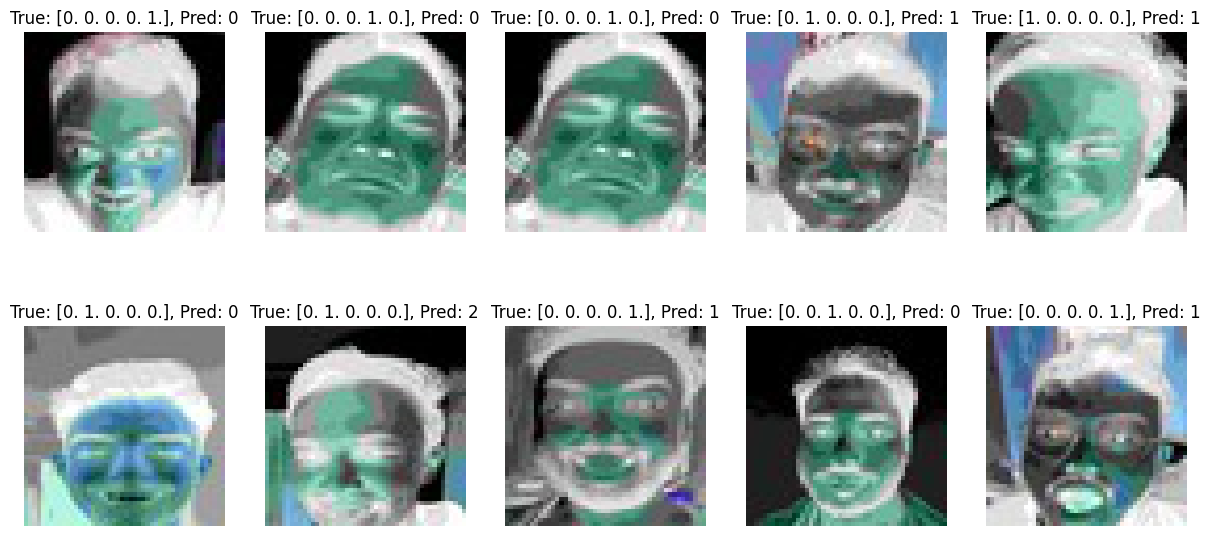

In [47]:
import numpy as np
import matplotlib.pyplot as plt
e = ['Angry','Happy','Neutral','Sad','Surprise']
for i in range(len(e)):
    print(i,"=",e[i])
# Get a batch of 10 random images from the test set
test_batch = validation_set.next()
images = test_batch[0][:10]
true_labels = test_batch[1][:10]

# Make predictions using the trained model
pred_probs = model.predict(images)
pred_labels = np.argmax(pred_probs, axis=1)

# Plot the images with their true and predicted labels
fig, axs = plt.subplots(2, 5, figsize=(15, 7))
axs = axs.flatten()

for i in range(len(images)):
    # Rescale the pixel values from [0, 1] to [0, 255] and convert to integers
    img = (images[i] * 255).astype(np.uint8)
    # Invert the pixel values
    img = 255 - img
    axs[i].imshow(img)
    axs[i].set_title(f'True: {true_labels[i]}, Pred: {pred_labels[i]}')
    axs[i].axis('off')

plt.show()

